# Diffusion models for ultrasound image generation

In this notebook, we will look at one of the current state-of-the-art deep generative models: diffusion models. These models have shown great promise in generating high-quality images and have been applied to various tasks, including [ultrasound synthesis](https://arxiv.org/abs/2305.05424), [inpainting](https://3d-ultrasound-diffusion.github.io/), but also [denoising / dehazing](https://dehazing-diffusion.github.io/) of ultrasound images. `zea.Models` supports some pretrained diffusion models, ready to perform prior and posterior sampling. We'll start, as always with setting the Keras backend.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/models/diffusion_model_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/models/diffusion_model_example.ipynb)
&nbsp;
[![Hugging Face model](https://img.shields.io/badge/Hugging%20Face-Model-yellow?logo=huggingface)](https://huggingface.co/zeahub/diffusion-echonet-dynamic)

In [ ]:
%%capture
%pip install zea

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
import keras
from zea import log, init_device
from zea.models.diffusion import DiffusionModel
from zea.ops import Pipeline, ScanConvert
from zea.data import Dataset
from zea.visualize import plot_image_grid, set_mpl_style
from zea.agent.selection import EquispacedLines
from zea.utils import translate

zea: Using backend 'jax'


We will work with the GPU if available, and initialize using `init_device` to pick the best available device. Also, (optionally), we will set the matplotlib style for plotting.

In [4]:
init_device(verbose=False)
set_mpl_style()

## Unconditional generation
Let's choose a pretrained diffusion model (on EchoNet Dynamic dataset) and generate some ultrasound images. Using `presets.keys()` we can see the available models. One could also point to a custom model by passing a local path to the model checkpoint directory.

In [5]:
presets = list(DiffusionModel.presets.keys())
log.info(f"Available built-in zea presets for DiffusionModel: {presets}")

model = DiffusionModel.from_preset("diffusion-echonet-dynamic")  # or use a local path to your model

# Prior sampling
prior_samples = model.sample(n_samples=16, n_steps=90, verbose=True)

zea: Available built-in zea presets for DiffusionModel: ['diffusion-echonet-dynamic']
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step


## Postprocessing
Now we have generated the images, we want to postprocess them a bit (in this case, scanconvert to Cartesian grid). We can use the `zea.Pipeline` class to easily create a processing pipeline.

In [ ]:
pipeline = Pipeline([ScanConvert(order=2, jit_compile=False)])
parameters = {
    "theta_range": [-0.78, 0.78],  # [-45, 45] in radians
    "rho_range": [0, 1],
}
processed_batch = keras.ops.squeeze(prior_samples, axis=-1)

parameters = pipeline.prepare_parameters(**parameters)
processed_batch = pipeline(data=processed_batch, **parameters)["data"]

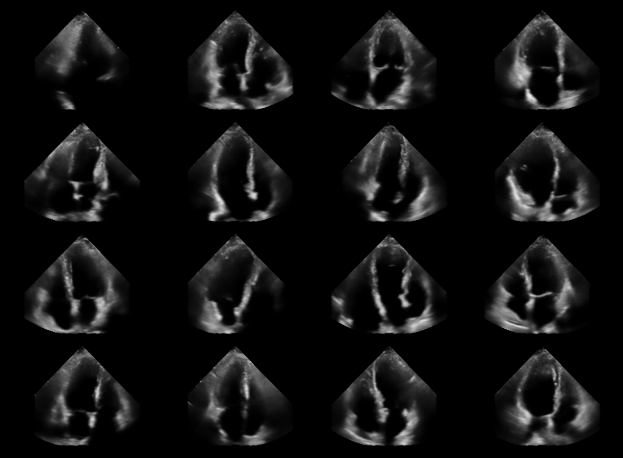

In [7]:
fig, _ = plot_image_grid(
    processed_batch,
    vmin=-1,
    vmax=1,
)

## Dataset loading

Generating unconditional ultrasound images is nice, but we can also perform a task with these generative diffusion models. For example, we can inpaint missing regions that were not acquired during the ultrasound scan. We can use the `posterior_sample()` method to generate samples conditioned on a measurement, given some measurement model. 

First we need some actual ultrasound data to condition on. We can use the `zea.Dataset` class to load a dataset from Huggingface, or from a local path.

In [8]:
dataset = Dataset("hf://zeahub/camus-sample/val", key="image")

data = dataset[0]["data"]["image"]

img_shape = model.input_shape[:2]

data = keras.ops.expand_dims(data, axis=-1)
data = keras.ops.image.resize(data, img_shape)
dynamic_range = (-40, 0)
data = keras.ops.clip(data, dynamic_range[0], dynamic_range[1])
data = translate(data, dynamic_range, (-1, 1))

zea: Using pregenerated dataset info file: /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/dataset_info.yaml ...
zea: ...for reading file paths in /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val
zea: Dataset was validated on June 15, 2025
zea: Remove /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag if you want to redo validation.
zea: ...for reading file paths in /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val
zea: Dataset was validated on June 15, 2025
zea: Remove /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.fla

We can then create the measurement, by subsampling the original data using a mask. 

In [9]:
line_thickness = 2
factor = 2
agent = EquispacedLines(
    n_actions=img_shape[1] // line_thickness // factor,
    n_possible_actions=img_shape[1] // line_thickness,
    img_width=img_shape[1],
    img_height=img_shape[0],
)

_, mask = agent.sample(batch_size=len(data))
mask = keras.ops.expand_dims(mask, axis=-1)

measurements = keras.ops.where(mask, data, -1.0)

## Posterior sampling (conditional generation)

Finally, we can use the `posterior_sample()` method to generate samples conditioned on the measurement. The `posterior_sample()` method takes a measurement and a measurement model as input, and returns a posterior sample. We can draw multiple samples and visualize the posterior variance as a proxy to see how uncertain the model is about the missing 
regions.

In [10]:
## Posterior sampling
posterior_samples = model.posterior_sample(
    measurements=measurements,
    mask=mask,
    n_samples=4,
    n_steps=200,
    omega=30.0,
    verbose=True,
)
posterior_variance = keras.ops.var(posterior_samples, axis=1)
posterior_samples = posterior_samples[:, 0]  # Get first sample only
# scale posterior variance to [-1, 1] range so it can be visualized
posterior_variance = translate(
    posterior_variance,
    (0, keras.ops.max(posterior_variance)),
    (-1, 1),
)

## Post processing (ScanConvert)
concatenated = [prior_samples, data, measurements, posterior_samples, posterior_variance]
# limit number of samples for visualization
concatenated = [sample[:4] for sample in concatenated]
concatenated = keras.ops.concatenate(concatenated, axis=0)
concatenated = keras.ops.squeeze(concatenated, axis=-1)

processed_batch = pipeline(data=concatenated, **parameters)["data"]

200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 118ms/step - error: 20045.3242
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 118ms/step - error: 20045.3242


And now let's visualize the results! We will show some prior samples, the original target images (CAMUS dataset), the measurement, and the posterior samples. We can also visualize the posterior variance as a proxy for uncertainty.

In short:
- **Prior samples**: x ~ p(x), sampled from the diffusion model trained on the EchoNet Dynamic dataset
- **Original image**: x, from the CAMUS dataset
- **Measurement**: y, a masked version of x
- **Posterior samples**: x ~ p(x|y), sampled from the diffusion model conditioned on the measurement y
- **Posterior variance**: Var[p(x|y)], visualized as a heatmap to show uncertainty in the posterior samples

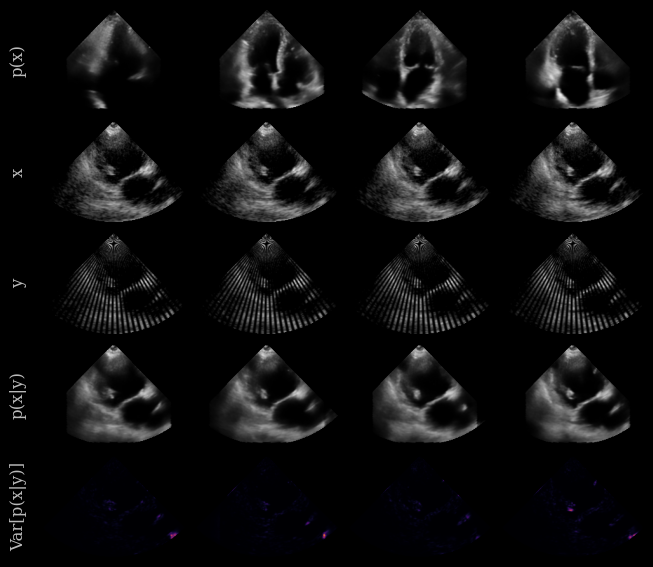

In [11]:
n_rows = 5  # prior, batch, measurements, posterior, posterior_variance
imgs_per_row = 4

cmaps = ["gray"] * ((n_rows - 1) * imgs_per_row) + ["inferno"] * imgs_per_row

## Plotting
fig, _ = plot_image_grid(
    processed_batch,
    vmin=-1,
    vmax=1,
    remove_axis=False,
    ncols=imgs_per_row,
    cmap=cmaps,
)

titles = ["p(x)", "x", "y", "p(x|y)", "Var[p(x|y)]"]

for i, title in enumerate(titles):
    fig.axes[i * imgs_per_row].set_ylabel(title)